# Tutorial: Reading and validating [LORENE](https://lorene.obspm.fr/) binary neutron star initial data

## Author(s): Leo Werneck & Zach Etienne

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Initialize core Python/NRPy+ modules and parameters
1. [Step 2](#adding_cfuncs_to_dict): Adding C functions to the dictionary
    1. [Step 2.a](#cfunc__id_lorene_adm_quantities): `ID_Lorene_ADM_quantities_Cartesian`
    1. [Step 2.b](#cfunc__set_hydro_quantities): `set_hydro_quantities`
    1. [Step 2.c](#cfunc__initial_data): `initial_data`
    1. [Step 2.d](#cfunc__hamiltonian_constraint_source_term): `Hamiltonian_constraint_source_term`
        1. [Step 2.d.i](#hydro_quantities_eos): The equation of state & derived hydrodynamics quantities 
        1. [Step 2.d.ii](#grmhd_rho): The energy density $\rho$
        1. [Step 2.d.iii](#adding_ham_constraint_source_term_to_dict): Adding the function to the dictionary
    1. [Step 2.e](#cfunc__hamiltonian_constraint_no_source_term): `Hamiltonian_constraint_no_source_term`
        1. [Step 2.e.i](#hamiltonian_constraint_no_source_symb): The Hamiltonian constraint without source terms
        1. [Step 2.e.ii](#adding_ham_constraint_no_source_term_to_dict): Adding the function to the dictionary
    1. [Step 2.f](#cfunc__main): `main`
1. [Step 3](#ccode_kernels_generation): C code kernels generation
    1. [Step 3.a](#cparams_rfm_and_domainsize): Set `free_parameters.h`; also output C codes needed for declaring and setting Cparameters
    1. [Step 3.b](#add_all): Add all NRPy+Lorene BNS initial data C codes to C function dictionary
    1. [Step 3.c](#generate_c_code): Generating C code for setting Lorene BNS initial data in NRPy+
1. [Step 4](#compiling_and_running): Compiling and running the code
1. [Step 5](#constraint_violations): Visualization: convergence of Hamiltonian constraint
1. [Step 6](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Initialize core Python/NRPy+ modules and parameters \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

Let's start by importing all the needed modules from Python/NRPy+:

In [1]:
# Step 1: Initialize core Python/NRPy+ modules and parameters
# Step 1.a: Add the NRPy+ base directory to the path
import os,sys,shutil            # Standard Python modules for multiplatform OS-level functions
nrpy_dir_path = os.path.join("..")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)

# Step 1.b: Import core NRPy+ modules
import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import outputC as outC          # NRPy+: Core C code output module
import finite_difference as fin # NRPy+: Finite difference C code generation module
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
import reference_metric as rfm  # NRPy+: Reference metric support
import NRPy_param_funcs as par  # NRPy+: Parameter interface
import indexedexp as ixp        # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import grid as gri              # NRPy+: Functions having to do with numerical grids
import tabulatedEOS.NRPyEOS.NRPyEOS as NRPyEOS

# Step 1.c: Check if lorene_standalone has been downloaded and compiled
if not os.path.exists(os.path.join("lorene_standalone", "Lorene", "Lib", "liblorenef77_g.a")):
    print("""# Error: Lorene hasn't been compiled yet. Please run the following from nrpytutorial/:
cd in_progress  # Make sure you're in the nrpytutorial root directory.
git clone https://bitbucket.org/zach_etienne/lorene_standalone.git
cd lorene_standalone/
# For "Lorene1": wget http://astro.phys.wvu.edu/zetienne/resu.d
# Lorene2 (latest):
wget --no-check-certificate https://ccrgpages.rit.edu/~jfaber/BNSID/Data/simple_polytrope/gam2.5/gam2.5_1.4_1.4/gam2.5_1.4_1.4_hr/gam2.5_1.4_1.4_hr_50/resu_5.000000e+01_1.520000e+00_1.520000e+00.d -O resu.d
cd Lorene/
HOME_LORENE=`pwd` make -j20
""")
    sys.exit(1)

# Step 1.d: Check if the initial data file exists
if not os.path.exists(os.path.join("lorene_standalone", "resu.d")):
    print("""# Error: resu.d not found.
# Be sure to go into nrpytutorial
# and run:
cd in_progress/lorene_standalone
# For "Lorene1": wget http://astro.phys.wvu.edu/zetienne/resu.d
# Lorene2 (latest):
wget --no-check-certificate https://ccrgpages.rit.edu/~jfaber/BNSID/Data/simple_polytrope/gam2.5/gam2.5_1.4_1.4/gam2.5_1.4_1.4_hr/gam2.5_1.4_1.4_hr_50/resu_5.000000e+01_1.520000e+00_1.520000e+00.d -O resu.d
""")
    sys.exit(1)

# Step P1: Create C code output directory:
Ccodesdir = os.path.join("lorene_standalone", "interpolator")
# Step P1.a: First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Step P1.b: Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P2: Set basic NRPy+ parameters
CoordSystem = "Cartesian"
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)

# Step P3: Set finite difference order
FD_order = 4
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",FD_order)

# Step P4: Enable rfm_precompute
enable_rfm_precompute = True

# Step P5: Disable FD_functions
enable_FD_functions = False

# Step P6: Disable SIMD
enable_SIMD = False

# Step P7: Parameter used to compute dt_min
thismodule = "Lorene_ID"
_wavespeed = par.Cparameters("REAL",thismodule,"wavespeed",1.0)
CFL_FACTOR = 0.5

# Step P8: Set grid parameters defaults
# Step P8.a: domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size     = 12.5 # Needed for all coordinate systems.

# Step P8.b: sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.2 # If Sinh* coordinates chosen

# Step P8.c: sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05 # If Sinh*v2 coordinates chosen

# Step P8.d: SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 1.0 # If SymTP chosen

# Step P9: Create rfm_files directory, if rfm_precompute is enabled
if enable_rfm_precompute:
    cmd.mkdir(os.path.join(Ccodesdir, "rfm_files/"))
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines","True")
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", os.path.join(Ccodesdir, "rfm_files/"))

# Step P10: Create SIMD directory and copy intrinsics, if SIMD is enabled
if enable_SIMD:
    cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
    shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesdir,"SIMD/"))

# Step P11: Set EOS type. Options are:
#           "polytrope" and "tabulated"
# EOS_type = "polytrope"
EOS_type = "tabulated"

<a id='adding_cfuncs_to_dict'></a>

# Step 2: Adding C functions to the dictionary \[Back to [top](#toc)\]
$$\label{adding_cfuncs_to_dict}$$

We will now add all C functions that we will need to read in the [LORENE](https://lorene.obspm.fr/) initial data and interpolate it onto the NRPy+ grids.

<a id='cfunc__id_lorene_adm_quantities'></a>

## Step 2.a: `ID_Lorene_ADM_quantities_Cartesian` \[Back to [top](#toc)\]
$$\label{cfunc__id_lorene_adm_quantities}$$

The first function we will write is the one that sets up the ADM quantities from the [LORENE](https://lorene.obspm.fr/) initial data file, typically named `resu.d`. NRPy+ needs us to define the following ADM quantities:

$$
\left(\alpha,\beta^{i},\gamma_{ij},K_{ij}\right),
$$

where $\alpha$ is the lapse function, $\beta^{i}$ is the shift vector, $\gamma_{ij}$ is the physical spatial metric, and $K_{ij}$ is the extrinsic curvature.

We note here that these quantities will all be read from the [LORENE](https://lorene.obspm.fr/) initial data file and the interpolated onto the NRPy+ grid in the `main` function [below](#cfunc__main).

In this step, we write the function `ID_Lorene_ADM_quantities_Cartesian`, which is required by the C functions generated by the [`ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py`](ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py) \[[**edit**](../edit/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py)\] NRPy+ module. The goal of this function is to initialize local variables for the ADM quantities above from a user-defined struct of type `ID_inputs`. In our case this is a very simple task since our struct, which is defined in [Step 3.c](#ccode_kernels__defines_prototypes) below, contains pointers to the [LORENE](https://lorene.obspm.fr/) gridfunctions arrays, and therefore all we need to do is copy over the data to our local variables at the particular gridpoint we are interested in.

Note that we also initialize $B^{i}$, which is used by the second-order Gamma-driver shift condition, to zero.

In [2]:
# Step 2: Adding C functions to the directionary
# Step 2.a: Adding ID_Lorene_ADM_quantities_Cartesian to the C functions dictionary
def add_to_Cfunction_dict_ID_Lorene_ADM_quantities_Cartesian():
    desc = """
(c) 2021 Leo Werneck
This function sets the initial data for all ADM quantities.
"""
    includes = ["NRPy_basic_defines.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "ID_Lorene_ADM_quantities_Cartesian"

    print("Writing "+name+" function")

    params   = """const paramstruct *restrict params,
                  const int i0i1i2[3],const REAL xyz_or_rthph[3],
                  const ID_inputs other_inputs,
                  REAL *gammaDD00,REAL *gammaDD01,REAL *gammaDD02,REAL *gammaDD11,REAL *gammaDD12,REAL *gammaDD22,
                  REAL *KDD00,REAL *KDD01,REAL *KDD02,REAL *KDD11,REAL *KDD12,REAL *KDD22,
                  REAL *alpha,
                  REAL *betaU0,REAL *betaU1,REAL *betaU2,
                  REAL *BU0,REAL *BU1,REAL *BU2"""
    body     = """
    // Set useful indices
    const int i0  = i0i1i2[0];
    const int i1  = i0i1i2[1];
    const int i2  = i0i1i2[2];
    const int idx = IDX3S(i0,i1,i2);

    // Lapse function alpha
    *alpha = other_inputs.alp[idx];

    // Shift vector beta^{i}
    *betaU0 = other_inputs.betax[idx];
    *betaU1 = other_inputs.betay[idx];
    *betaU2 = other_inputs.betaz[idx];

    // B^{i}
    *BU0 = 0.0;
    *BU1 = 0.0;
    *BU2 = 0.0;

    // Spatial metric gamma_{ij}
    *gammaDD00 = other_inputs.gxx[idx];
    *gammaDD01 = other_inputs.gxy[idx];
    *gammaDD02 = other_inputs.gxz[idx];
    *gammaDD11 = other_inputs.gyy[idx];
    *gammaDD12 = other_inputs.gyz[idx];
    *gammaDD22 = other_inputs.gzz[idx];

    // Extrinsic curvature K_{ij}
    *KDD00 = other_inputs.kxx[idx];
    *KDD01 = other_inputs.kxy[idx];
    *KDD02 = other_inputs.kxz[idx];
    *KDD11 = other_inputs.kyy[idx];
    *KDD12 = other_inputs.kyz[idx];
    *KDD22 = other_inputs.kzz[idx];
"""
    loopopts = "InteriorPoints"
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,enableCparameters=True)

    print("Finished writing "+name+" function")

<a id='cfunc__set_hydro_quantities'></a>

## Step 2.b: `set_hydro_quantities` \[Back to [top](#toc)\]
$$\label{cfunc__set_hydro_quantities}$$

We now focus on the task of setting up the hydro quantities needed by our code, namely

$$
\left(\rho_{\rm b},u^{\mu},b^{\mu}\right),
$$

where $\rho_{\rm b}$ is the baryonic density, $u^{\mu}$ is the fluid four-velocity, and $b^{\mu}$ is related to the magnetic field $B^{i}$ via (see e.g. Eqs. 31, 23, and 24 of [Duez *et al*. (2005)](https://arxiv.org/pdf/astro-ph/0503420.pdf))

$$
\begin{align}
b^{\mu} &= \frac{B^{\mu}_{(u)}}{\sqrt{4\pi}},\\
B^{0}_{(u)} &= \frac{u_{i}B^{i}}{\alpha},\\
B^{i}_{(u)} &= \frac{B^{i}/\alpha + B^{0}_{(u)}u^{i}}{u^{0}}.
\end{align}
$$

We will assume that our initial data is unmagnetized and therefore will set $b^{\mu} = 0$. Note also that other hydro quantities, such as the pressure $P$ and the specific internal energy $\epsilon$, can be computed from the base quantities above and therefore we will not store them in gridfunctions.

The [LORENE](https://lorene.obspm.fr/) initial data file contains the base hydro quantities that we need in our code, namely the baryonic density $\rho_{\rm b}$ and the fluid 3-velocity in the Eulerian reference frame $v^{i}_{(n)}$. We are then left with the task of computing $u^{\mu}$ from the input data, a task which we now explain in detail.

After reading in the local value of $v^{i}_{(n)}$ must determine $u^{0}$. This is done by first remembering that the [Lorentz factor](https://en.wikipedia.org/wiki/Lorentz_factor), $W$, is given by

$$
W = \frac{1}{\sqrt{1 - \gamma_{ij}v^{i}_{(n)}v^{j}_{(n)}}}.
$$

Furthermore, remember that (see e.g. Eq. 15 in [Noble *et al*. (2006)](https://arxiv.org/pdf/astro-ph/0512420.pdf), noticing that they use the notation $W\to\gamma$)

$$
W = -n_{\mu}u^{\mu} = \alpha u^{0},
$$

where $n_{\mu}=\left(\alpha,0,0,0\right)$ is the unit vector normal to spatial hypersurfaces. We thus find the identity

$$
\frac{1}{W^{2}} = \frac{1}{\left(\alpha u^{0}\right)^{2}} = 1 - \gamma_{ij}v^{i}_{(n)}v^{j}_{(n)}
\implies
A \equiv 1 - \frac{1}{\left(\alpha u^{0}\right)^{2}} = \gamma_{ij}v^{i}_{(n)}v^{j}_{(n)}.
$$

After $A$ is computed we can determine $u^{0}$ trivially using

$$
\frac{1}{\left(\alpha u^{0}\right)^{2}} = 1 - A \implies u^{0} = \frac{1}{\alpha\sqrt{1-A}}.
$$

At this point we can compute the fluid 3-velocity $u^{i}$ using (see e.g. Eq. 10 [Etienne *et al.* (2015)](https://arxiv.org/pdf/1501.07276.pdf))

$$
u^{i} = u^{0}\left(\alpha v^{i}_{(n)} - \beta^{i}\right).
$$

In [3]:
# Step 2.b: Adding set_hydro_quantities to the C functions dictionary
def add_to_Cfunction_dict_set_hydro_quantities():
    desc = """
(c) 2021 Leo Werneck
This function sets the initial data for all hydro quantities.
"""
    includes = ["NRPy_basic_defines.h","bin_ns.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "set_hydro_quantities"
    params   = """const paramstruct *restrict params, const ID_inputs other_inputs, REAL *restrict aux_gfs"""
    body     = r"""
    // Set the index
    const int idx = IDX3S(i0,i1,i2);

    // Read in needed metric quantities
    const REAL alpL   = other_inputs.alp[idx];
    const REAL gxxL   = other_inputs.gxx[idx];
    const REAL gxyL   = other_inputs.gxy[idx];
    const REAL gxzL   = other_inputs.gxz[idx];
    const REAL gyyL   = other_inputs.gyy[idx];
    const REAL gyzL   = other_inputs.gyz[idx];
    const REAL gzzL   = other_inputs.gzz[idx];
    const REAL betaxL = 0.0;//other_inputs.betax[idx];
    const REAL betayL = 0.0;//other_inputs.betay[idx];
    const REAL betazL = 0.0;//other_inputs.betaz[idx];

    // rho_b (don't forget that we need to floor it!)
    const REAL rho_b = std::max(other_inputs.nbar[idx] / other_inputs.rho_b_unit,1e-12);

    // Velocities (remember that Lorene gives the Valencia velocity)
    REAL velx = other_inputs.u_euler_x[idx];
    REAL vely = other_inputs.u_euler_y[idx];
    REAL velz = other_inputs.u_euler_z[idx];

    // Adapted from IllinoisGRMHD
    REAL vsqrd = gxxL * velx * velx +
             2.0*gxyL * velx * vely +
             2.0*gxzL * velx * velz +
                 gyyL * vely * vely +
             2.0*gyzL * vely * velz +
                 gzzL * velz * velz;

    // Apply velocity limit (W is the Lorentz factor)
    REAL W     = 1.0/sqrt(1.0 - vsqrd);
    REAL W_max = 10.0;
    if( W > W_max ) {
        REAL correction_fac = W_max/W;
        velx *= correction_fac;
        vely *= correction_fac;
        velz *= correction_fac;
        W = W_max;
        fprintf(stderr,"BAAAD: Initial data with very high velocities!\n");
    }

    // Now compute u^{mu}
    // Remember that: W = alpha u^{0} => u^{0} = W/alpha
    const REAL u4U0 = W/alpL;
    const REAL u4U1 = u4U0 * ( velx * alpL - betaxL );
    const REAL u4U2 = u4U0 * ( vely * alpL - betayL );
    const REAL u4U3 = u4U0 * ( velz * alpL - betazL );

    // Set the gridfunctions
    aux_gfs[IDX4ptS(RHOBGF,idx)] = rho_b;
    aux_gfs[IDX4ptS(U4U0GF,idx)] = u4U0;
    aux_gfs[IDX4ptS(U4U1GF,idx)] = u4U1;
    aux_gfs[IDX4ptS(U4U2GF,idx)] = u4U2;
    aux_gfs[IDX4ptS(U4U3GF,idx)] = u4U3;

    // TODO: extend to nonzero magnetic fields
    aux_gfs[IDX4ptS(SMALLB4U0GF,idx)] = 0.0;
    aux_gfs[IDX4ptS(SMALLB4U1GF,idx)] = 0.0;
    aux_gfs[IDX4ptS(SMALLB4U2GF,idx)] = 0.0;
    aux_gfs[IDX4ptS(SMALLB4U3GF,idx)] = 0.0;
"""

    if EOS_type == "tabulated":
        body += """
    // Set electron fraction and temperature
    aux_gfs[IDX4ptS(YEGF         ,idx)] = other_inputs.Y_e;//[idx];
    aux_gfs[IDX4ptS(TEMPERATUREGF,idx)] = other_inputs.T;//[idx];
"""

    loopopts = "AllPoints"
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,loopopts=loopopts)

    print("Finished writing "+name+" function")

<a id='cfunc__initial_data'></a>

## Step 2.c: `initial_data` \[Back to [top](#toc)\]
$$\label{cfunc__initial_data}$$

We now write the core initial data driver function, which is the only one that the user has to directly use to set up initial data. This function performs the following tasks:

1. Initializes all BSSN curvilinear quantities from the input ADM quantities. This is a two-step process, where the functions `ID_BSSN__ALL_BUT_LAMBDAs` and `ID_BSSN_lambdas`, defined by the [`ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py`](ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py) \[[**edit**] NRPy+ module, are called.
1. Initializes all hydro quantities. This is done by calling the `set_hydro_quantities` function that we have written in [Step 2.b](cfunc__set_hydro_quantities).

In [4]:
# Step 2.c: initial_data
# Step 2.c.i: First add the core NRPy+ ADM_Cartesian to
#             BSSN_Curvilinear C functions to the dictionary
import ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as atob
rfm.reference_metric()
atob.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Cartesian","ID_Lorene_ADM_quantities_Cartesian",
                                                            Ccodesdir=Ccodesdir,loopopts="")

# Step 2.c.ii: Adding initial_data to the C functions dictionary
def add_to_Cfunction_dict_initial_data():
    desc     = """
(c) 2021 Leo Werneck
This is the initial data driver and is responsible for setting
all metric and matter field on the initial hypersurface.
"""
    includes = ["NRPy_basic_defines.h","NRPy_function_prototypes.h",
                "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h",
                "ID_BSSN__ALL_BUT_LAMBDAs.h",
                "ID_BSSN_lambdas.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "initial_data"

    print("Writing "+name+" function")

    params   = """const paramstruct *restrict params,REAL *restrict xx[3],ID_inputs other_inputs,
                  REAL *restrict in_gfs,REAL *restrict aux_gfs"""
    body     = r"""

    // Set up hydro quantities
    set_hydro_quantities(params,other_inputs,aux_gfs);

    // Set up BSSN quantities
    ID_BSSN__ALL_BUT_LAMBDAs(params,xx,other_inputs,in_gfs);
    ID_BSSN_lambdas(         params,xx,             in_gfs);
"""
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,enableCparameters=False)

    print("Finished writing "+name+" function")

Output C function ID_BSSN_lambdas() to file lorene_standalone/interpolator/ID_BSSN_lambdas.h
Output C function ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs() to file lorene_standalone/interpolator/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h
Output C function ID_BSSN__ALL_BUT_LAMBDAs() to file lorene_standalone/interpolator/ID_BSSN__ALL_BUT_LAMBDAs.h


<a id='cfunc__hamiltonian_constraint_source_term'></a>

## Step 2.d: `Hamiltonian_constraint_source_term` \[Back to [top](#toc)\]
$$\label{cfunc__hamiltonian_constraint_source_term}$$

We now focus on the computation of the energy density $\rho$ which appears on the right-hand side of the [Hamiltonian constriant](../Tutorial-BSSN_stress_energy_source_terms.ipynb). The definition of the energy density is (cf. Eq. 10a in [Baumgarte *et al.* (2013)](https://arxiv.org/pdf/1211.6632.pdf))

$$
\rho \equiv n_{\mu}n_{\nu}T^{\mu\nu}.
$$

Here, $T^{\mu\nu} = T^{\mu\nu}_{\rm GRMHD}$ is the energy-momentum tensor of general relativistic magnetohydrodynamics (GRMHD) and is given by (cf. Eq. 33 in [Duez *et al*. (2005)](https://arxiv.org/pdf/astro-ph/0503420.pdf))

$$
T^{\mu\nu}_{\rm GRMHD} = \left(\rho_{b}h + b^{2}\right)u^{\mu}u^{\nu} + \left(P^{2} + \frac{b^{2}}{2}\right)g^{\mu\nu} - b^{\mu}b^{\nu},
$$

where $h = 1 + \epsilon + P/\rho$ is the specific enthalpy, $P$ is the pressure, $b^{2}\equiv b_{\mu}b^{\mu}$, and $g^{\mu\nu}$ is the inverse of the spacetime metric $g_{\mu\nu}$.

<a id='hydro_quantities_eos'></a>

### Step 2.d.i: The equation of state & derived hydrodynamics quantities \[Back to [top](#toc)\]
$$\label{hydro_quantities_eos}$$

We must now compute some of the derived hydrodynamics quantities defined above, such as the pressure and specific internal energy. We compute these quantities by employing an [equation of state (EOS)](https://en.wikipedia.org/wiki/Equation_of_state). We will assume here a very simple EOS which is known as a [simple polytrope](https://en.wikipedia.org/wiki/Polytrope). This EOS relates the pressure with the baryonic density via

$$
P(\rho_{\rm b}) = K \rho_{\rm b}^{\Gamma},
$$

where $K$ is a constant of proportinality and $\Gamma$ is the adiabatic index. From this we can determine the specific internal energy using

$$
\epsilon = \int d\rho_{\rm b} \frac{P}{\rho_{\rm b}^{2}} = K\int d\rho_{\rm b} \rho_{\rm b}^{\Gamma-2} = \frac{K\rho_{\rm b}^{\Gamma-1}}{\Gamma-1} = \frac{P}{\rho_{\rm b}\left(\Gamma-1\right)},
$$

where we have fixed the integration constant to zero by demanding that $\lim_{\rho_{\rm b}\to0}\epsilon=0$.

In [5]:
# Step 2.d.i: Derived hydro quantities
# Step 2.d.i.A: Register rho_b as an auxiliary gridfunction
rho_b = gri.register_gridfunctions("AUX","rhob")

if EOS_type == "tabulated":
    # Register Y_e and T as auxiliary gridfunctions
    gri.register_gridfunctions("AUX",["Ye", "Temperature"])

if EOS_type == "polytrope":
    # Step 2.d.i.B: Define K and Gamma as symbols
    K,Gamma = sp.symbols("K Gamma",real=True)

    # Step 2.d.i.C: Compute the pressure: P = K rho_{b}^Gamma
    P = K * rho_b**Gamma

    # Step 2.d.i.D: Compute the specific internal energy: epsilon = P/( rho_{b}(Gamma-1) )
    epsilon = P / ( rho_b*(Gamma-1) )

elif EOS_type == "tabulated":
    P,epsilon = sp.symbols("P eps",real=True)

<a id='grmhd_rho'></a>

### Step 2.d.ii: The energy density $\rho$ \[Back to [top](#toc)\]
$$\label{grmhd_rho}$$

We now compute the symbolic expressions for the GRMHD energy density $\rho$. This requires a few steps, which we outline below:

1. Define symbolic expressions for the ADM variables used by the C code
1. Define symbolic expressions for $u^{\mu}$ and $b^{\mu}$ used by the C code
1. Use the function `compute_smallbsquared` from the [GRFFE/equations.py](../GRFFE/equations.py) \[[**edit**](../edit/GRFFE/equations.py), [**tutorial**](../Tutorial-GRFFE_Equations-Cartesian.ipynb)\] NRPy+ module to compute $b^{2}$.
1. Use the function `compute_GRMHD_T4UU` from the [GRMHD/equations.py](../GRMHD/equations.py) \[[**edit**](../edit/GRMHD/equations.py), [**tutorial**](../Tutorial-GRMHD_Equations-Cartesian.ipynb)\] NRPy+ module to compute $T^{\mu\nu}_{\rm GRMHD}$.
1. Declare symbolic expressions for $n_{\mu} = \left(-\alpha,0,0,0\right)$.
1. Compute $\rho = n_{\mu}n_{\nu}T^{\mu\nu}_{\rm GRMHD}$.

In [6]:
# Step 2.d.ii: The energy density rho
# Step 2.d.ii.A: Import GRFFE/equations.py and GRMHD/equations.py NRPy+ modules
import GRFFE.equations as GRFFE
import GRMHD.equations as GRMHD
import BSSN.ADMBSSN_tofrom_4metric as AB4m

# Step 2.d.ii.B: Define symbolic expressions for metric quantities
DIM     = 3
alpha   = sp.Symbol("other_inputs.alp[IDX3S(i0,i1,i2)]",real=True)
betaU   = ixp.zerorank1()
gammaDD = ixp.zerorank2()
for i in range(DIM):
    betaU[i] = sp.Symbol("other_inputs.beta"+chr(ord('x')+i)+"[IDX3S(i0,i1,i2)]",real=True)
    for j in range(i,DIM):
        gammaDD[i][j] = gammaDD[j][i] = sp.Symbol("other_inputs.g"+chr(ord('x')+i)+chr(ord('x')+j)+"[IDX3S(i0,i1,i2)]",real=True)

gammaUU,_ = ixp.symm_matrix_inverter3x3(gammaDD)

# Step 2.d.ii.C: Define symbolic expressions for hydro quantities
u4U      = ixp.register_gridfunctions_for_single_rank1("AUX","u4U",DIM=4)
smallb4U = ixp.register_gridfunctions_for_single_rank1("AUX","smallb4U",DIM=4)

# Step 2.d.ii.D: b^{2} = b_{\mu}b^{\mu}
GRFFE.compute_smallbsquared(gammaDD, betaU, alpha, smallb4U)

# Step 2.d.ii.E: Compute the GRMHD energy-momentum tensor
GRMHD.compute_GRMHD_T4UU(gammaDD,betaU,alpha, rho_b,P,epsilon,u4U, smallb4U, GRFFE.smallbsquared)

# Step 2.d.ii.F: ADM 4-metric
AB4m.g4DD_ito_BSSN_or_ADM("ADM",gammaDD=gammaDD,betaU=betaU,alpha=alpha)

# Step 2.d.ii.G: Unit 4-vector
n4D    = ixp.zerorank1(DIM=4)
n4D[0] = -alpha

# Step 2.d.ii.H: Induced metric
gamma4DD = ixp.zerorank2(DIM=4)
for mu in range(4):
    for nu in range(4):
        gamma4DD[mu][nu] = AB4m.g4DD[mu][nu] + n4D[mu] * n4D[nu]

# Step 2.d.ii.I: Energy density
rhoADM = sp.sympify(0)
for mu in range(4):
    for nu in range(4):
        rhoADM += n4D[mu] * n4D[nu] * GRMHD.T4UU[mu][nu]

# Step 2.d.ii.J: Momentum density
SD = ixp.zerorank1()
for i in range(3):
    for mu in range(4):
        for nu in range(4):
            SD[i] += - gamma4DD[i+1][mu] * n4D[nu] * GRMHD.T4UU[mu][nu]

# Step 2.d.ii.L: S^{i} = gamma^{ij}S_{j}
SU = ixp.zerorank1()
for i in range(3):
    for j in range(3):
        SU[i] += gammaUU[i][j] * SD[j]

# Step 2.d.ii.K: Sources
M_PI     = par.Cparameters("REAL", thismodule, ["M_PI"], "3.14159265358979323846264338327950288")
sourceH  = -16 * M_PI * rhoADM
sourceMU = ixp.zerorank1()
for i in range(3):
    sourceMU[i] = -8 * M_PI * SU[i] / rfm.ReU[i]

<a id='adding_ham_constraint_source_term_to_dict'></a>

### Step 2.d.iii: Adding the function to the dictionary \[Back to [top](#toc)\]
$$\label{adding_ham_constraint_source_term_to_dict}$$

Having defined everything we need, we now add the function `Hamiltonian_constraint_source_term` to our C function dictionary.

In [7]:
# Step 2.e.i: The Hamiltonian constraint without source terms
# Step 2.e.i.A: Import the BSSN/BSSN_constraints.py NRPy+ module
import BSSN.BSSN_constraints as bssncon
import BSSN.BSSN_stress_energy_source_terms as Bsest

# Step 2.e.i.B: Adjust reference metric environment if rfm_precompute is enabled
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
    rfm.reference_metric()

# Step 2.e.i.C: Now register the Hamiltonian constraint as an auxiliary gridfunction
H  = gri.register_gridfunctions("AUX","H")
MU = ixp.register_gridfunctions_for_single_rank1("AUX","MU")
_  = gri.register_gridfunctions("AUX","sourceH")
_  = ixp.register_gridfunctions_for_single_rank1("AUX","sourceMU")

# Step 2.e.i.D: Set symbolic expressions for the constraints
bssncon.BSSN_constraints(add_T4UUmunu_source_terms=False)

# Step 2.e.i.E: Reset the reference metric environment if rfm_precompute is enabled
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::enable_rfm_precompute","False")
    rfm.ref_metric__hatted_quantities()

<a id='cfunc__hamiltonian_constraint_no_source_term'></a>

## Step 2.e: `Hamiltonian_constraint_no_source_term` \[Back to [top](#toc)\]
$$\label{cfunc__hamiltonian_constraint_no_source_term}$$

In [8]:
# Step 2.d.iii: Adding Hamiltonian_constraint_source_term
#               to the C functions dictionary
def add_to_Cfunction_dict_Hamiltonian_and_momentum_constraints_source_terms():
    desc = """
(c) 2021 Leo Werneck
This function computes the energy density rho, which appears
in the source term of the Hamiltonian constraint.
"""
    includes = ["NRPy_basic_defines.h"]
    if EOS_type == "tabulated":
        includes.append("NRPy_function_prototypes.h")

    prefunc  = ""
    c_type   = "void"
    name     = "Hamiltonian_and_momentum_constraints_source_terms"

    print("Writing "+name+" function")

    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                  NRPyEOS_params *restrict eos_params, ID_inputs other_inputs,
                  REAL *restrict aux_gfs"""
    body     = """
    const int idx        = IDX3S(i0,i1,i2);
    const REAL rhob      = aux_gfs[IDX4ptS(RHOBGF,idx)];
    const REAL u4U0      = aux_gfs[IDX4ptS(U4U0GF,idx)];
    const REAL u4U1      = aux_gfs[IDX4ptS(U4U1GF,idx)];
    const REAL u4U2      = aux_gfs[IDX4ptS(U4U2GF,idx)];
    const REAL u4U3      = aux_gfs[IDX4ptS(U4U3GF,idx)];
    const REAL smallb4U0 = aux_gfs[IDX4ptS(SMALLB4U0GF,idx)];
    const REAL smallb4U1 = aux_gfs[IDX4ptS(SMALLB4U1GF,idx)];
    const REAL smallb4U2 = aux_gfs[IDX4ptS(SMALLB4U2GF,idx)];
    const REAL smallb4U3 = aux_gfs[IDX4ptS(SMALLB4U3GF,idx)];

"""
    if EOS_type == "polytrope":
        body += """
    const REAL K     = eos_params->K;
    const REAL Gamma = eos_params->Gamma;
"""
    elif EOS_type == "tabulated":
        body += """
    const REAL Y_e = aux_gfs[IDX4ptS(YEGF,idx)];
    const REAL T   = aux_gfs[IDX4ptS(TEMPERATUREGF,idx)];
    REAL P,eps;
    NRPyEOS_P_and_eps_from_rho_Ye_T(eos_params,rhob,Y_e,T,&P,&eps);
"""
    body += outC.outputC([sourceH,
                          sourceMU[0],
                          sourceMU[1],
                          sourceMU[2]],
                         [gri.gfaccess("aux_gfs", "sourceH"),
                          gri.gfaccess("aux_gfs", "sourceMU0"),
                          gri.gfaccess("aux_gfs", "sourceMU1"),
                          gri.gfaccess("aux_gfs", "sourceMU2")], "returnstring",
                         params="outCverbose=False,includebraces=False")
    loopopts = "InteriorPoints"
    if enable_SIMD:
        loopopts +=",enable_SIMD"
    if enable_rfm_precompute:
        loopopts +=",enable_rfm_precompute"
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,loopopts=loopopts)

    print("Finished writing "+name+" function")

<a id='hamiltonian_constraint_no_source_symb'></a>

### Step 2.e.i: The Hamiltonian constraint without source terms \[Back to [top](#toc)\]
$$\label{hamiltonian_constraint_no_source_symb}$$

We now declare the symbolic expression for the Hamiltonian constraint by invoking the [`BSSN/BSSN_constraints.py`](../BSSN/BSSN_constraints.py) \[[**edit**](../edit/BSSN/BSSN_constraints.py), [**tutorial**](../Tutorial-BSSN_constraints.ipynb)\] NRPy+ module.

In [9]:
# Step 2.e.ii: Adding Hamiltonian_constraint_no_source_term
#              to the C functions dictionary
def add_to_Cfunction_dict_Hamiltonian_and_momentum_constraints_no_source_terms():
    desc = """
(c) 2021 Leo Werneck
This function computes the metric terms of the Hamiltonian constraint.
"""
    includes = ["NRPy_basic_defines.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "Hamiltonian_and_momentum_constraints_no_source_terms"

    print("Writing "+name+" function")

    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                  REAL *restrict in_gfs, REAL *restrict aux_gfs"""
    body     = """
    const int idx        = IDX3S(i0,i1,i2);
    const REAL rhob      = aux_gfs[IDX4ptS(RHOBGF,idx)];
    const REAL u4U0      = aux_gfs[IDX4ptS(U4U0GF,idx)];
    const REAL u4U1      = aux_gfs[IDX4ptS(U4U1GF,idx)];
    const REAL u4U2      = aux_gfs[IDX4ptS(U4U2GF,idx)];
    const REAL u4U3      = aux_gfs[IDX4ptS(U4U3GF,idx)];
    const REAL smallb4U0 = aux_gfs[IDX4ptS(SMALLB4U0GF,idx)];
    const REAL smallb4U1 = aux_gfs[IDX4ptS(SMALLB4U1GF,idx)];
    const REAL smallb4U2 = aux_gfs[IDX4ptS(SMALLB4U2GF,idx)];
    const REAL smallb4U3 = aux_gfs[IDX4ptS(SMALLB4U3GF,idx)];
\n"""+fin.FD_outputC("returnstring",
                     [outC.lhrh(lhs=gri.gfaccess("aux_gfs", "H")  , rhs=bssncon.H),
                      outC.lhrh(lhs=gri.gfaccess("aux_gfs", "MU0"), rhs=bssncon.MU[0]),
                      outC.lhrh(lhs=gri.gfaccess("aux_gfs", "MU1"), rhs=bssncon.MU[1]),
                      outC.lhrh(lhs=gri.gfaccess("aux_gfs", "MU2"), rhs=bssncon.MU[2])],
                      params="outCverbose=False")
    loopopts = "InteriorPoints,enable_rfm_precompute"
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,loopopts=loopopts)

    print("Finished writing "+name+" function")

<a id='cfunc__main'></a>

## Step 2.f: `main` \[Back to [top](#toc)\]
$$\label{cfunc__main}$$

We now add the `main` function to the C functions dictionary. This function combines all the other functions that we have defined this far into a C program that is able to:

1. Set a NRPy+ grid.
1. Convert the NRPy+ grid to Cartesian coordinates, which is the coordinate system expected by [LORENE](https://lorene.obspm.fr/).
1. Read the initial data from the input `resu.d` file and interpolate the solution onto the NRPy+ grid.
1. Set up BSSN and GRMHD quantities from the input.
1. Compute the Hamiltonian constraint violations on the NRPy+ grid.
1. Output the results to file.

In [10]:
# Step 2.f: Adding main to the C functions dictionary
def add_to_Cfunction_dict_main():
    print("Writing main function")
    desc = """
(c) 2009 Erik Schnetter
(c) 2010 Frank Loeffler
Edits by Z Etienne & L Werneck 2021
"""

    includes = ["<cstdio>", "<cstring>", "<vector>", "<ios>", "<iostream>",
                "assert.h", "stdlib.h", "bin_ns.h", "unites.h",
                "NRPy_basic_defines.h","NRPy_function_prototypes.h"]

    prefunc = r"""
using namespace std;

// define namespace here for old versions of Lorene that don't do so
namespace Lorene {}
using namespace Lorene;
"""

    c_type = "int"
    name = "main"

    print("Writing "+name+" function")

    params = "int argc, const char *argv[]"
    if EOS_type == "polytrope":
        body = r"""
  // Step 0: Check correct usage
  if((argc < 9) || (argc > 10)) {
    fprintf(stderr,"Error, incorrect usage. Usage: ./standalone_interpolator [Nx0] [Nx1] [Nx2] [offset_axis] [offset_star_1] [offset_star_2] [Gamma] [filename (resu.d)] [(optional) initial shift (zero or lorene)]\n");
    exit(1);
  }
"""
    elif EOS_type == "tabulated":
        body = r"""
  // Step 0: Check correct usage
  if((argc < 11) || (argc > 12)) {
    fprintf(stderr,"Error, incorrect usage. Usage: ./standalone_interpolator [Nx0] [Nx1] [Nx2] [offset_axis] [offset_star_1] [offset_star_2] [eos_table_path] [Ye_file_path] [Initial temperature (MeV)] [filename (resu.d)] [(optional) initial shift (zero or lorene)]\n");
    exit(1);
  }
"""

    body += r"""
  // Step 0.a: Set up physical constants for converting quantities
  //           from SI units (Lorene) to Geometrized units (NRPy)
  // Be aware: these are the constants Lorene uses. They do differ from other
  // conventions, but they gave the best results in some tests.
  double const c_light  = Unites::c_si;      // speed of light [m/s]
  double const nuc_dens = Unites::rhonuc_si; // Nuclear density as used in Lorene units [kg/m^3]
  double const G_grav   = Unites::g_si;      // gravitational constant [m^3/kg/s^2]
  double const M_sun    = Unites::msol_si;   // solar mass [kg]

  // Step 0.b: Geometrized units in terms of SI units:
  // (These are derived from M = M_sun, c = G = 1,
  // and using 1/M_sun for the magnetic field)
  double const geomM = M_sun;
  double const geomL = geomM * G_grav / pow(c_light,2);
  double const geomT = geomL / c_light;

  // Step 0.c: Other quantities
  double const coord_unit = geomL / 1.0e+3;       // from km (~1.477)
  double const rho_b_unit = geomM / pow(geomL,3); // from kg/m^3

  printf("coord_unit = %.15e\n",coord_unit);

  // Step 0.d: Set initial shift from user input or default to zero
  char initial_shift[256];
  if( argc == 10 ) {
    sprintf(initial_shift,"%s",argv[9]);
  }
  else {
    sprintf(initial_shift,"%s","zero");
  }

  // Step 0.f: Set up numerical grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
    printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }

  int offset_index;
  REAL offset_star1_xyz[3] = {0,0,0};
  REAL offset_star2_xyz[3] = {0,0,0};
  char offset_axis[10];
  sprintf(offset_axis,"%s",argv[4]);

  if( !strcmp(offset_axis,"x") ) {
    offset_index = 0;
  }
  else if( !strcmp(offset_axis,"y") ) {
    offset_index = 1;
  }
  else if( !strcmp(offset_axis,"z") ) {
    offset_index = 2;
  }
  else {
    fprintf(stderr,"Error: unsupported offset axis: %s. Supported options are: x, y, and z\n",offset_axis);
    exit(1);
  }
  offset_star1_xyz[offset_index] = strtod(argv[5],NULL) / coord_unit;
  offset_star2_xyz[offset_index] = strtod(argv[6],NULL) / coord_unit;

  printf("Beginning analysis of Lorene initial data.\n");
  printf("Grid #1 will be centered at (x,y,z) = (%g,%g,%g)\n",offset_star1_xyz[0],offset_star1_xyz[1],offset_star1_xyz[2]);
  printf("Grid #2 will be centered at (x,y,z) = (%g,%g,%g)\n",offset_star2_xyz[0],offset_star2_xyz[1],offset_star2_xyz[2]);
  printf("Grid #3 will be centered at (x,y,z) = (0,0,0)\n");

  const int ngrids = 1;
  for(int n_grid=1;n_grid<=ngrids;n_grid++) {

    printf("Beginning analysis of Grid #%d\n",n_grid);

    // Step 0.e: Set up NRPy parameter struct
    paramstruct params;
    set_Cparameters_to_default(&params);

    // Step 0.g: Set free parameters, overwriting Cparameters defaults
    //           by hand or with command-line input, as desired.
#include "free_parameters.h"

    if(n_grid == 1) {
      params.Cart_originx = offset_star1_xyz[0];
      params.Cart_originy = offset_star1_xyz[1];
      params.Cart_originz = offset_star1_xyz[2];
      //params.RMAX         = 24;
    }
    else if(n_grid == 2) {
      params.Cart_originx = offset_star2_xyz[0];
      params.Cart_originy = offset_star2_xyz[1];
      params.Cart_originz = offset_star2_xyz[2];
      //params.RMAX         = 24;
    }

    // Step 0.h: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];

    // Step 0.i: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //           params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //           chosen (non-Eigen) CoordSystem.
    int EigenCoord = 1;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0.j: Set all C parameters "blah" for params.blah, including
    //           Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0.l: Allocate memory for initial data gridfunctions on NRPy grid
    REAL *id_gfs  = (REAL *)malloc(NUM_EVOL_GFS*Nxx_plus_2NGHOSTS_tot*sizeof(REAL));
    REAL *aux_gfs = (REAL *)malloc(NUM_AUX_GFS*Nxx_plus_2NGHOSTS_tot*sizeof(REAL));

    // Step 0.m: Set up precomputed reference metric arrays
    // Step 0.m.i: Allocate space for precomputed reference metric arrays.
    rfm_struct rfmstruct;
    rfm_precompute_rfmstruct_malloc(&params, &rfmstruct);

    // Step 0.m.ii: Define precomputed reference metric arrays.
    {
#include "set_Cparameters-nopointer.h"
      rfm_precompute_rfmstruct_define(&params, xx, &rfmstruct);
    }

    // LORENE COORDINATES, != NRPy COORDINATES
    vector<double> x_Lorene(Nxx_plus_2NGHOSTS_tot);
    vector<double> y_Lorene(Nxx_plus_2NGHOSTS_tot);
    vector<double> z_Lorene(Nxx_plus_2NGHOSTS_tot);

#pragma omp parallel for
    for(int i2=0;i2<Nxx_plus_2NGHOSTS2;i2++) {
      for(int i1=0;i1<Nxx_plus_2NGHOSTS1;i1++) {
        for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++) {
          const int idx = IDX3S(i0,i1,i2);
          REAL xCart[3];
          xx_to_Cart(&params,xx,i0,i1,i2,xCart);
          x_Lorene[idx] = xCart[0] * coord_unit;
          y_Lorene[idx] = xCart[1] * coord_unit;
          z_Lorene[idx] = xCart[2] * coord_unit;
        }
      }
    }

    // --------------------------------------------------------------
    //   CHECKING FILE NAME EXISTENCE
    // --------------------------------------------------------------
    FILE *file;
    char filename[100];"""
    if EOS_type == "polytrope":
        body += r"""sprintf(filename,"%s",argv[8]);"""
    elif EOS_type == "tabulated":
        body += r"""sprintf(filename,"%s",argv[10]);"""

    body += r"""
    if ((file = fopen(filename, "r")) != NULL)
      fclose(file);
    else {
      fprintf(stderr,
              "File \"%s\" does not exist. ABORTING\n", filename);
      exit(1);
    }

    printf( "Reading from file \"%s\"\n", filename);


    Bin_NS bin_ns(Nxx_plus_2NGHOSTS_tot, &x_Lorene[0], &y_Lorene[0], &z_Lorene[0], filename);

    printf( "omega [rad/s]:       %g\n", bin_ns.omega);
    printf( "dist [km]:           %g\n", bin_ns.dist);
    printf( "dist_mass [km]:      %g\n", bin_ns.dist_mass);
    printf( "mass1_b [M_sun]:     %g\n", bin_ns.mass1_b);
    printf( "mass2_b [M_sun]:     %g\n", bin_ns.mass2_b);
    printf( "mass_ADM [M_sun]:    %g\n", bin_ns.mass_adm);
    printf( "L_tot [G M_sun^2/c]: %g\n", bin_ns.angu_mom);
    printf( "rad1_x_comp [km]:    %g\n", bin_ns.rad1_x_comp);
    printf( "rad1_y [km]:         %g\n", bin_ns.rad1_y);
    printf( "rad1_z [km]:         %g\n", bin_ns.rad1_z);
    printf( "rad1_x_opp [km]:     %g\n", bin_ns.rad1_x_opp);
    printf( "rad2_x_comp [km]:    %g\n", bin_ns.rad2_x_comp);
    printf( "rad2_y [km]:         %g\n", bin_ns.rad2_y);
    printf( "rad2_z [km]:         %g\n", bin_ns.rad2_z);
    printf( "rad2_x_opp [km]:     %g\n", bin_ns.rad2_x_opp);
"""
    if EOS_type == "polytrope":
        body += r"""
    double K = bin_ns.kappa_poly1 * pow((pow(c_light, 6.0) /
                                         ( pow(G_grav, 3.0) * M_sun * M_sun *
                                           nuc_dens )),bin_ns.gamma_poly1-1.);
    printf( "K [ET unit]:         %.15g\n", K);
    double Gamma = strtod(argv[7],NULL);
    printf( "Gamma:               %g\n", Gamma);
    
    NRPyEOS_params eos_params;
    eos_params.K = K;
    eos_params.Gamma = Gamma;
"""
    elif EOS_type == "tabulated":
        body += r"""
    NRPyEOS_params eos_params;
    NRPyEOS_readtable_set_EOS_params(argv[7], &eos_params);
    //NRPyEOS_set_initial_Ye(argv[8], &params, xx, &other_inputs);
    const REAL T_initial = strtod(argv[9],  NULL);
"""

    body += r"""
    assert(bin_ns.np == Nxx_plus_2NGHOSTS_tot);

    printf("Filling in NRPy grid points\n");

    // Set up the initial data struct
    ID_inputs other_inputs;
    other_inputs.alp           = bin_ns.nnn;
    other_inputs.gxx           = bin_ns.g_xx;
    other_inputs.gxy           = bin_ns.g_xy;
    other_inputs.gxz           = bin_ns.g_xz;
    other_inputs.gyy           = bin_ns.g_yy;
    other_inputs.gyz           = bin_ns.g_yz;
    other_inputs.gzz           = bin_ns.g_zz;
    other_inputs.kxx           = bin_ns.k_xx;
    other_inputs.kxy           = bin_ns.k_xy;
    other_inputs.kxz           = bin_ns.k_xz;
    other_inputs.kyy           = bin_ns.k_yy;
    other_inputs.kyz           = bin_ns.k_yz;
    other_inputs.kzz           = bin_ns.k_zz;
    other_inputs.betax         = bin_ns.beta_x;
    other_inputs.betay         = bin_ns.beta_y;
    other_inputs.betaz         = bin_ns.beta_z;
    other_inputs.u_euler_x     = bin_ns.u_euler_x;
    other_inputs.u_euler_y     = bin_ns.u_euler_y;
    other_inputs.u_euler_z     = bin_ns.u_euler_z;
    other_inputs.nbar          = bin_ns.nbar;
    other_inputs.rho_b_unit    = rho_b_unit;
"""
    if EOS_type == "tabulated":
        body +=r"""
#pragma omp parallel for
    for(int i2=0;i2<Nxx_plus_2NGHOSTS2;i2++)
      for(int i1=0;i1<Nxx_plus_2NGHOSTS1;i1++)
        for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++) {
          other_inputs.T = T_initial;
          // FIXME
          other_inputs.Y_e = 0.5;
        }
"""
    body += r"""
  {
    FILE * fp = fopen("vx_vy_vz_NRPy.x.asc","w");
    const int j = Nxx_plus_2NGHOSTS1/2;
    const int k = Nxx_plus_2NGHOSTS2/2;
    for(int i=NGHOSTS;i<Nxx_plus_2NGHOSTS0-NGHOSTS;i++) {
      const int ijk = IDX3S(i,j,k);
      REAL xCart[3];
      xx_to_Cart(&params,xx,i,j,k,xCart);
      fprintf(fp,"%e %e %e %e\n",xCart[0],
              other_inputs.u_euler_x[ijk],
              other_inputs.u_euler_y[ijk],
              other_inputs.u_euler_z[ijk]);
    }
    fclose(fp);
  }

    // Change units in K_{ij} and set beta^{i} to zero, if requested by the user
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot;i++) {
      other_inputs.kxx[i] *= coord_unit;
      other_inputs.kxy[i] *= coord_unit;
      other_inputs.kxz[i] *= coord_unit;
      other_inputs.kyy[i] *= coord_unit;
      other_inputs.kyz[i] *= coord_unit;
      other_inputs.kzz[i] *= coord_unit;
      if(strcmp(initial_shift,"zero")) {
        other_inputs.betax[i] = 0.0;
        other_inputs.betay[i] = 0.0;
        other_inputs.betaz[i] = 0.0;
      }
    }

    // Compute BSSN quantities from ADM Cartesian quantities
    printf("Initializing BSSN & hydro quantities...\n");
    initial_data(&params,xx,other_inputs,id_gfs,aux_gfs);

    // Compute Hamiltonian constraint violation
    printf("Computing costraint violations...\n");
    Hamiltonian_and_momentum_constraints_no_source_terms(&rfmstruct,&params,id_gfs,aux_gfs);
    Hamiltonian_and_momentum_constraints_source_terms(&rfmstruct,&params,&eos_params,other_inputs,aux_gfs);

    {
      printf("Outputting 1D data...\n");
      // 1D data
      char filename[256];
      sprintf(filename,"initial_data_grid_%d.x.asc",n_grid);
      FILE* fp = fopen(filename,"w");
      const int i1_out = Nxx_plus_2NGHOSTS1/2;
      const int i2_out = Nxx_plus_2NGHOSTS2/2;
      for(int i0=NGHOSTS;i0<Nxx_plus_2NGHOSTS0-NGHOSTS;i0++) {
        REAL xCart[3];
        xx_to_Cart(&params,xx,i0,i1_out,i2_out,xCart);

        const int idx = IDX3S(i0,i1_out,i2_out);
        const REAL H     = aux_gfs[IDX4ptS(HGF,idx)] + aux_gfs[IDX4ptS(SOURCEHGF,idx)];
        const REAL Mx    = aux_gfs[IDX4ptS(MU0GF,idx)] - aux_gfs[IDX4ptS(SOURCEMU0GF,idx)];
        const REAL My    = aux_gfs[IDX4ptS(MU1GF,idx)] - aux_gfs[IDX4ptS(SOURCEMU1GF,idx)];
        const REAL Mz    = aux_gfs[IDX4ptS(MU2GF,idx)] - aux_gfs[IDX4ptS(SOURCEMU2GF,idx)];
        const REAL rho_b = aux_gfs[IDX4ptS(RHOBGF,idx)];
        const REAL alp   = id_gfs[IDX4ptS(ALPHAGF,idx)];
        const REAL cf    = id_gfs[IDX4ptS(CFGF,idx)];
        const REAL cfm2  = 1.0/(cf*cf);
        const REAL gxx   = cfm2*(1.0 + id_gfs[IDX4ptS(HDD00GF,idx)]);
        const REAL gyy   = cfm2*(1.0 + id_gfs[IDX4ptS(HDD11GF,idx)]);
        const REAL gzz   = cfm2*(1.0 + id_gfs[IDX4ptS(HDD22GF,idx)]);
        const REAL u0    = aux_gfs[IDX4ptS(U4U0GF,idx)];
        const REAL ux    = aux_gfs[IDX4ptS(U4U1GF,idx)];
        const REAL uy    = aux_gfs[IDX4ptS(U4U2GF,idx)];
        const REAL uz    = aux_gfs[IDX4ptS(U4U3GF,idx)];
        const REAL vx    = ux/u0;
        const REAL vy    = uy/u0;
        const REAL vz    = uz/u0;
        fprintf(fp,"%.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e\n",
                xCart[0],xCart[1],xCart[2],H,Mx,My,Mz,rho_b,alp,gxx,gyy,gzz,vx,vy,vz);
      }
      /*
      i2_out = Nxx_plus_2NGHOSTS2/2;
      for(int i0=NGHOSTS;i0<Nxx_plus_2NGHOSTS0-NGHOSTS;i0++) {
        REAL xCart[3];
        xx_to_Cart(&params,xx,i0,i1_out,i2_out,xCart);

        const int idx    = IDX3S(i0,i1_out,i2_out);
        const REAL H     = aux_gfs[IDX4ptS(HGF,idx)] - 16.0*M_PI*aux_gfs[IDX4ptS(RHOADMGF,idx)];
        const REAL rho_b = aux_gfs[IDX4ptS(RHOBGF,idx)];
        const REAL alp   = id_gfs[IDX4ptS(ALPHAGF,idx)];
        const REAL cf    = id_gfs[IDX4ptS(CFGF,idx)];
        const REAL cfm2  = 1.0/(cf*cf);
        const REAL gxx   = cfm2*(1.0 + id_gfs[IDX4ptS(HDD00GF,idx)]);
        const REAL gyy   = cfm2*(1.0 + id_gfs[IDX4ptS(HDD11GF,idx)]);
        const REAL gzz   = cfm2*(1.0 + id_gfs[IDX4ptS(HDD22GF,idx)]);
        fprintf(fp,"%.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e\n",xCart[0],H,rho_b,alp,gxx,gyy,gzz);
      }
      */
      fclose(fp);
    }
    {
      printf("Outputting 2D data...\n");
      // 2D data
      char filename[256];
      sprintf(filename,"initial_data_grid_%d.xy.asc",n_grid);
      FILE* fp = fopen(filename,"w");
      const int i2_out = Nxx_plus_2NGHOSTS2/2;
      for(int i1=0;i1<Nxx_plus_2NGHOSTS1;i1++) {
        for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++) {
          REAL xCart[3];
          xx_to_Cart(&params,xx,i0,i1,i2_out,xCart);
          const int idx = IDX3S(i0,i1,i2_out);
          fprintf(fp,"%e %e %e\n",xCart[0],xCart[1],aux_gfs[IDX4ptS(RHOBGF,idx)]);
        }
        fprintf(fp,"\n");
      }
      fclose(fp);
    }

    for(int i=0;i<3;i++) free(xx[i]);
    free(id_gfs);
    free(aux_gfs);
"""
    if EOS_type == "tabulated":
        body += "NRPyEOS_free_memory(&eos_params);\n"

    body += r"""
    printf("Done.\n");
  }

"""
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body, enableCparameters=False)

    print("Finished writing "+name+" function")

<a id='ccode_kernels_generation'></a>

# Step 3: C code kernels generation \[Back to [top](#toc)\]
$$\label{ccode_kernels_generation}$$

We now generate the C code kernels that are needed by our program. These include:

1. `free_parameters.h`: a file containing initialization values for all the free parameters in our program.
1. All the C functions that we have added to the C functions dictionary.
1. `NRPy_basic_defines.h`: a C header file that contains all the data structures and definitions which are used by NRPy+ programs.
1. `NRPy_function_prototypes.h`: a C header file that contains the prototypes of all the functions that have been added to the C functions dictionary.

<a id='cparams_rfm_and_domainsize'></a>

## Step 3.a: Set `free_parameters.h`; also output C codes needed for declaring and setting Cparameters  \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

First we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above.

In [11]:
# Step 3.a.i: Set free_parameters.h
with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write("""
// Free parameters related to physical system:
params.wavespeed = 1.0;

// Free parameters related to numerical timestep:
REAL CFL_FACTOR = """+str(CFL_FACTOR)+";\n")

# Step 3.a.2: Append to $Ccodesrootdir/free_parameters.h reference metric parameters
#             based on generic domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#             parameters set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

<a id='add_all'></a>

## Step 3.b: Add all NRPy+Lorene BNS initial data C codes to C function dictionary \[Back to [top](#toc)\]
$$\label{add_all}$$

In [12]:
# Step 3.b: Add all NRPy+Lorene BNS C codes to C function to dictionary
def BNS_Initial_Data_NRPyLorene_register_C_functions(Ccodesdir):
    add_to_Cfunction_dict_ID_Lorene_ADM_quantities_Cartesian()
    add_to_Cfunction_dict_set_hydro_quantities()
    add_to_Cfunction_dict_initial_data()
    add_to_Cfunction_dict_Hamiltonian_and_momentum_constraints_source_terms()
    add_to_Cfunction_dict_Hamiltonian_and_momentum_constraints_no_source_terms()
    add_to_Cfunction_dict_main()
    if EOS_type == "tabulated":
        list_of_function_parameters = [[NRPyEOS.P,NRPyEOS.eps]]
        NRPyEOS.NRPyEOS_generate_interpolators_and_add_all_Cfuncs_to_dict(Ccodesdir,list_of_function_parameters)

<a id='generate_c_code'></a>

## Step 3.c: Generating C code for setting Lorene BNS initial data in NRPy+ \[Back to [top](#toc)\]
$$\label{generate_c_code}$$

In [13]:
# Step 3.c: Generating C code for setting Lorene BNS initial data in NRPy+
# Step 3.c.i: Generate all the C codes for the C functions
BNS_Initial_Data_NRPyLorene_register_C_functions(Ccodesdir)

# Step 3.c.ii: Define a custom dictionary entry for NRPy_basic_defines.h
def generate_supplementary_dict():
    supplementary_dict = {}
    Lorene_ID_string = r"""
typedef struct of_ID_inputs {
  // This struct is used to store Lorene
  // initial data in Cartesian basis
  REAL *alp,*betax,*betay,*betaz;
  REAL *gxx,*gxy,*gxz,*gyy,*gyz,*gzz;
  REAL *kxx,*kxy,*kxz,*kyy,*kyz,*kzz;
  REAL *nbar, *u_euler_x,*u_euler_y,*u_euler_z;
  REAL rho_b_unit;
"""
    if EOS_type == "tabulated":
        Lorene_ID_string += "  REAL Y_e, T;\n" # "  REAL *Y_e, *T;\n"
    Lorene_ID_string += "} ID_inputs;\n"

    supplementary_dict["Lorene_ID"] = Lorene_ID_string
    if EOS_type == "polytrope":
        supplementary_dict["NRPyEOS"] = r"""
typedef struct NRPyEOS_params {
  REAL K,Gamma;
} NRPyEOS_params;
"""
    elif EOS_type == "tabulated":
        NRPyEOS.add_NRPyEOS_header_to_supplementary_dict(supplementary_dict)
    return supplementary_dict

# Step 3.c.iii: Register all NRPy+ related C functions and
#               add entries to NRPy_basic_defines.h
outC.outputC_register_C_functions_and_NRPy_basic_defines()  # #define M_PI,  etc.
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(directory=Ccodesdir)
gri.register_C_functions_and_NRPy_basic_defines(enable_griddata_struct=False)  # #define IDX3S(),  etc.
rfm.register_C_functions(enable_rfm_precompute=enable_rfm_precompute)
rfm.register_NRPy_basic_defines(enable_rfm_precompute=enable_rfm_precompute)
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=False)

# Step 3.c.iv: Output functions for computing all finite-difference stencils.
#              Must be called after defining all functions depending on FD stencils.
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesdir)

# Step 3.c.v: Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesdir, enable_SIMD=enable_SIMD,
                                    supplemental_dict=generate_supplementary_dict())
outC.construct_NRPy_function_prototypes_h(Ccodesdir)

Writing ID_Lorene_ADM_quantities_Cartesian function
Finished writing ID_Lorene_ADM_quantities_Cartesian function
Finished writing set_hydro_quantities function
Writing initial_data function
Finished writing initial_data function
Writing Hamiltonian_and_momentum_constraints_source_terms function
Finished writing Hamiltonian_and_momentum_constraints_source_terms function
Writing Hamiltonian_and_momentum_constraints_no_source_terms function
Finished writing Hamiltonian_and_momentum_constraints_no_source_terms function
Writing main function
Writing main function
Finished writing main function


<a id='compiling_and_running'></a>

# Step 4: Compiling and running the code \[Back to [top](#toc)\]
$$\label{compiling_and_running}$$

In [14]:
data_dir = os.path.join("lorene_standalone","interpolator")

outfile_1 = os.path.join(data_dir,"initial_data_grid_1.x.asc")
outfile_2 = os.path.join(data_dir,"initial_data_grid_2.x.asc")
outfile_3 = os.path.join(data_dir,"initial_data_grid_3.x.asc")

# outfile_1_lr = os.path.join(data_dir,"initial_data_grid_1_lr.x.asc")
# outfile_2_lr = os.path.join(data_dir,"initial_data_grid_2_lr.x.asc")
# outfile_3_lr = os.path.join(data_dir,"initial_data_grid_3_lr.x.asc")

# outfile_1_hr = os.path.join(data_dir,"initial_data_grid_1_hr.x.asc")
# outfile_2_hr = os.path.join(data_dir,"initial_data_grid_2_hr.x.asc")
# outfile_3_hr = os.path.join(data_dir,"initial_data_grid_3_hr.x.asc")

addl_CFLAGS    = ["-I../Lorene/Export/C++/Include","-I../Lorene/C++/Include"]
addl_libraries = ["-L../Lorene/Lib/",
                  "-llorene_export", "-llorene",
                  "-llorenef77", "-lgfortran", "-lfftw3", "-lgsl",
                  "-lgslcblas", "-llapack", "-lblas"]

if EOS_type == "tabulated":
    addl_CFLAGS.append("-I/usr/local/opt/hdf5/include")
    addl_libraries.append("-L/usr/local/opt/hdf5/lib")
    addl_libraries.append("-lhdf5")

cmd.new_C_compile(Ccodesdir, "interpolator",
                  addl_CFLAGS=addl_CFLAGS,
                  addl_libraries=addl_libraries,
                  CC="g++")

# shutil.copy(outfile_1,outfile_1_lr)
# shutil.copy(outfile_2,outfile_2_lr)
# shutil.copy(outfile_3,outfile_3_lr)

# os.chdir(Ccodesdir)
# cmd.Execute("interpolator", "128 32 32 x 25 -25 2.5 ../resu.d")
# os.chdir(os.path.join("..",".."))

# shutil.copy(outfile_1,outfile_1_hr)
# shutil.copy(outfile_2,outfile_2_hr)
# shutil.copy(outfile_3,outfile_3_hr)

(EXEC): Executing `make -j10`...
ld: warning: ld: warning: dylib (/usr/local/opt/gsl/lib/libgsl.dylib) was built for newer macOS version (11.0) than being linked (10.16)
dylib (/usr/local/opt/fftw/lib/libfftw3.dylib) was built for newer macOS version (11.3) than being linked (10.16)
ld: warning: dylib (/usr/local/opt/gsl/lib/libgslcblas.dylib) was built for newer macOS version (11.0) than being linked (10.16)
ld: warning: dylib (/usr/local/opt/hdf5/lib/libhdf5.dylib) was built for newer macOS version (11.0) than being linked (10.16)
(BENCH): Finished executing in 4.878343820571899 seconds.
Finished compilation.


In [23]:
os.chdir(Ccodesdir)
if EOS_type == "polytrope":
    cmd.Execute("interpolator", "40 40 40 x 25 -25 2.5 ../resu_lowres.d","out.txt")
elif EOS_type == "tabulated":
    with open("Y_e.dummy","w") as file:
        file.write("")
    cmd.Execute("interpolator", "40 40 40 x 25 -25 /Users/werneck//eos_tables/LS220_234r_136t_50y_analmu_20091212_SVNr26.h5 Y_e.dummy 1 ../resu_lowres.d","out.txt")
os.chdir(os.path.join("..",".."))

(EXEC): Executing `./interpolator 40 40 40 x 25 -25 /Users/werneck//eos_tables/LS220_234r_136t_50y_analmu_20091212_SVNr26.h5 Y_e.dummy 1 ../resu_lowres.d`...
(NRPyEOS) *******************************
(NRPyEOS) Reading EOS table from file:
(NRPyEOS) /Users/werneck//eos_tables/LS220_234r_136t_50y_analmu_20091212_SVNr26.h5
(NRPyEOS) *******************************
(NRPyEOS) *******************************
(NRPyEOS) Freeing up memory.
(NRPyEOS) All done!
(NRPyEOS) *******************************
(BENCH): Finished executing in 1.4396731853485107 seconds.


<a id='constraint_violations'></a>

# Step 5: Visualization: convergence of Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{constraint_violations}$$

In [24]:
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import Image

# outfile_1_etk  = os.path.join("ETK_data","ETK_data_lr_40.asc")
# outfile_2_etk  = os.path.join("ETK_data","ETK_data_mr_40.asc")
# outfile_3_etk  = os.path.join("ETK_data","ETK_data_hr_40.asc")
# outfile_1_nrpy = os.path.join(data_dir,"initial_data_grid_lr_40.x.asc")
# outfile_2_nrpy = os.path.join(data_dir,"initial_data_grid_mr_40.x.asc")
# outfile_3_nrpy = os.path.join(data_dir,"initial_data_grid_hr_40.x.asc")

# data_1_etk  = np.loadtxt(outfile_1_etk).T
# data_2_etk  = np.loadtxt(outfile_2_etk).T
# data_3_etk  = np.loadtxt(outfile_3_etk).T
# data_1_nrpy = np.loadtxt(outfile_1_nrpy).T
# data_2_nrpy = np.loadtxt(outfile_2_nrpy).T
# data_3_nrpy = np.loadtxt(outfile_3_nrpy).T

# fig = plt.figure()

# plt.grid()
# plt.ylabel(r"$\log_{10}\left|\mathcal{H}\right|$")
# plt.xlabel(r"$x$ [km]")
# plt.plot(data_1_etk[0],np.log10(np.maximum(np.abs(data_1_etk[4][:]),1e-15)),'blue',label=r"ETK, low spectral resolution")
# plt.plot(data_1_nrpy[0],np.log10(np.maximum(np.abs(data_1_nrpy[3][:]),1e-15)),'orange',ls='--',label="NRPy+, low spectral resolution")
# plt.plot(data_2_etk[0],np.log10(np.maximum(np.abs(data_2_etk[4][:]),1e-15)),'purple',label=r"ETK, med spectral resolution")
# plt.plot(data_2_nrpy[0],np.log10(np.maximum(np.abs(data_2_nrpy[3][:]),1e-15)),'cyan',ls='--',label="NRPy+, med spectral resolution")
# plt.plot(data_3_etk[0],np.log10(np.maximum(np.abs(data_3_etk[4][:]),1e-15)),'green',ls=":",label=r"ETK, high spectral resolution")
# plt.plot(data_3_nrpy[0],np.log10(np.maximum(np.abs(data_3_nrpy[3][:]),1e-15)),'red',ls='-.',label="NRPy+, high spectral resolution")
# plt.legend()

# outfig = "constraint_violations.png"
# plt.savefig(outfig,dpi=150,facecolor='white')
# plt.close(fig)
# Image(outfig)

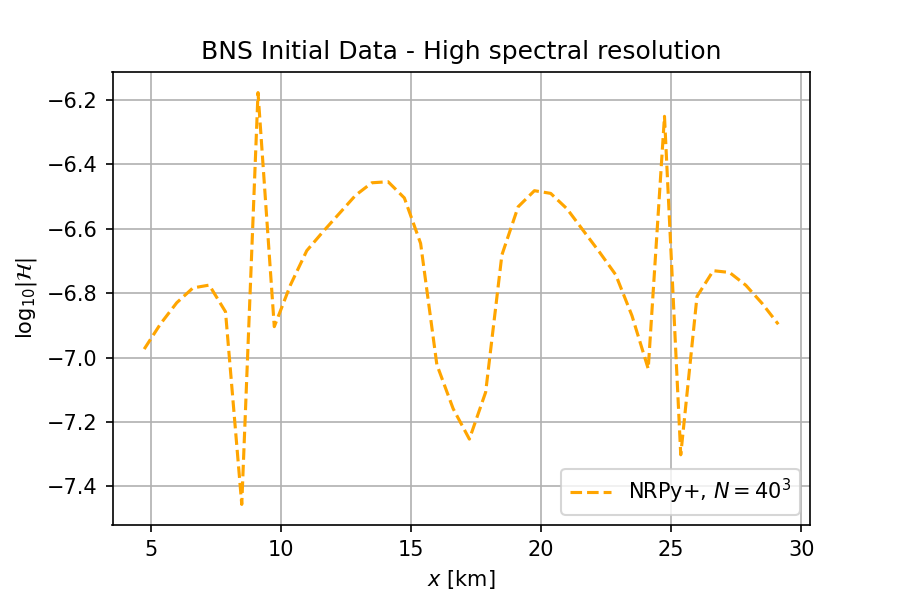

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# outfile_1_etk  = os.path.join("ETK_data","ETK_data_lr_40.asc")
# outfile_2_etk  = os.path.join("ETK_data","ETK_data_hr_80.asc")
outfile_1_nrpy = os.path.join(data_dir,"initial_data_grid_1.x.asc")
# outfile_2_nrpy = os.path.join(data_dir,"initial_data_grid_hr_80.x.asc")

# data_1_etk  = np.loadtxt(outfile_1_etk).T
# data_2_etk  = np.loadtxt(outfile_2_etk).T
data_1_nrpy = np.loadtxt(outfile_1_nrpy).T
# data_2_nrpy = np.loadtxt(outfile_2_nrpy).T

fig = plt.figure()

plt.title("BNS Initial Data - High spectral resolution")
plt.grid()
plt.ylabel(r"$\log_{10}\left|\mathcal{H}\right|$")
plt.xlabel(r"$x$ [km]")
# plt.plot(data_1_etk[0],np.log10(np.maximum(np.abs(data_1_etk[7][:]),1e-15)),'blue',label=r"ETK, $N=40^{3}$")
plt.plot(data_1_nrpy[0],np.log10(np.maximum(np.abs(data_1_nrpy[6][:]),1e-15)),'orange',ls='--',label="NRPy+, $N=40^{3}$")
# plt.plot(data_2_etk[0],np.log10(np.maximum(np.abs(data_2_etk[4][:]),1e-15)),'green',ls=":",label=r"ETK, $N=80^{3}$")
# plt.plot(data_2_nrpy[0],np.log10(np.maximum(np.abs(data_2_nrpy[3][:]),1e-15)),'red',ls='-.',label="NRPy+, $N=80^{3}$")
plt.legend()

outfig = "constraint_violations.png"
plt.savefig(outfig,dpi=150,facecolor='white')
plt.close(fig)
Image(outfig)

In [18]:
# fig,axs = plt.subplots(figsize=(9,3),ncols=3,nrows=1,sharex=True)
# for i in range(len(axs)):
#     axs[i].plot(grid_etk_v_data_lr[0],grid_etk_v_data_lr[idx],c="red",ls=":",label="vel ETK")
#     axs[i].plot(grid_etk_v_data_lr[0],grid_etk_v_data_lr[idx+3],c="magenta",ls=":",label="v ETK")
#     axs[i].plot(vels_nrpy[0],vels_nrpy[idx],c='black',ls="-.",label="vel NRPy")
#     axs[i].grid()
#     axs[i].legend()

# plt.tight_layout()
# plt.savefig("velocities.png",dpi=150,facecolor='white')
# plt.close(fig)
# Image("velocities.png")

In [19]:
# outfile_1_etk      = os.path.join("ETK_data","all_data.asc")
# # outfile_1_etk_vel  = os.path.join("ETK_data","vx_vy_vz.x.asc")
# grid_etk_x_data_lr = np.loadtxt(outfile_1_etk).T
# grid_1_x_data_lr   = np.loadtxt(outfile_1).T
# # grid_etk_v_data_lr = np.loadtxt(outfile_1_etk_vel).T
# # vels_nrpy          = np.loadtxt(os.path.join(data_dir,"vx_vy_vz_NRPy.x.asc")).T

# X    = 0
# H    = 4
# ALP  = 9
# GXX  = 13
# GYY  = 16
# GZZ  = 18
# RHOB = 25
# VELX = 26
# VELY = VELX+1
# VELZ = VELY+1
# VX   = 29
# VY   = VX+1
# VZ   = VY+1

# fig,axs = plt.subplots(figsize=(9,4.5),ncols=3,nrows=3,sharex=True)
# axs = axs.flatten()
# ylabels = [r"$\log_{10}\left|\mathcal{H}\right|$",
#            r"$\alpha$",
#            r"$\rho_{b}$",
#            r"$\gamma_{xx}$",
#            r"$\gamma_{yy}$",
#            r"$\gamma_{zz}$",
#            r"$v^{x} = u^{x}/u^{0}$",
#            r"$v^{y} = u^{y}/u^{0}$",
#            r"$v^{z} = u^{z}/u^{0}$"]
# qETK = [np.log10(np.maximum(np.abs(grid_etk_x_data_lr[H][:]),1e-15)),
#         grid_etk_x_data_lr[ALP],grid_etk_x_data_lr[RHOB],
#         grid_etk_x_data_lr[GXX],grid_etk_x_data_lr[GYY],grid_etk_x_data_lr[GZZ],
#         grid_etk_x_data_lr[VX],grid_etk_x_data_lr[VY],grid_etk_x_data_lr[VZ]]

# # xCart[0],xCart[1],xCart[2],H,rho_b,alp,gxx,gyy,gzz,vx,vy,vz
# qNRPy =[np.log10(np.maximum(np.abs(grid_1_x_data_lr[3][:]),1e-15)),
#         grid_1_x_data_lr[5],grid_1_x_data_lr[4],
#         grid_1_x_data_lr[6],grid_1_x_data_lr[7],grid_1_x_data_lr[8],
#         grid_1_x_data_lr[9],grid_1_x_data_lr[10],grid_1_x_data_lr[11]]

# for i in range(len(axs)):
#     axs[i].grid()
#     axs[i].set_ylabel(ylabels[i])
#     axs[i].plot(grid_etk_x_data_lr[0],qETK[i],c='blue',ls='-',label="ETK")
#     axs[i].plot(grid_1_x_data_lr[0],qNRPy[i],c='orange',ls='--',label="NRPy+")
#     axs[i].legend()

# plt.tight_layout()
# outfig = "constraint_violations.png"
# plt.savefig(outfig,dpi=150,facecolor='white')
# plt.close(fig)
# Image(outfig)

In [20]:
# import glob

# file_list = sorted(glob.glob(os.path.join("ETK_data","*.x.asc")))

# master_file = os.path.join("ETK_data","ETK_data_mr_40.asc")
# all_data   = []
# local_data = np.loadtxt(file_list[0]).T
# all_data.append(local_data[9])
# all_data.append(local_data[12])
# for i in range(1,len(file_list)):
#     local_data = np.loadtxt(file_list[i]).T
#     all_data.append(local_data[12])

# np.savetxt(master_file,list(zip(*all_data)))

In [21]:
# string  = "# Column 1: x\n"
# counter = 2
# for i in file_list:
#     string  += "# Column "+str(counter)+": "+i.split(".")[0].split("/")[1]+"\n"
#     counter += 1
# print(string)

<a id='latex_pdf_output'></a>

# Step 6: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-ADM_Initial_Data-Lorene_BNS.pdf](Tutorial-ADM_Initial_Data-Lorene_BNS.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [22]:
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-ADM_Initial_Data-Lorene_BNS")

Created Tutorial-ADM_Initial_Data-Lorene_BNS.tex, and compiled LaTeX file
    to PDF file Tutorial-ADM_Initial_Data-Lorene_BNS.pdf
